In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [38]:
from numpy.random import choice
from numpy.random import seed

In [39]:
# Dataset
iris = datasets.load_iris()
data = pd.DataFrame(iris.data, columns=iris.feature_names)
target = iris.target_names
labels = iris.target

In [40]:
# Scaling

scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [41]:
# PCA Transformation

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(data)
PCAdf = pd.DataFrame(data=principalComponents,
                     columns=['principal component 1', 'principal component 2', 'principal component 3'])

datapoints = PCAdf.values
m, f = datapoints.shape
k = 3

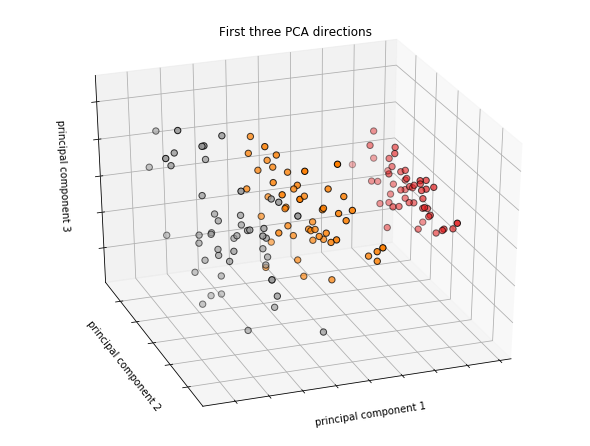

In [42]:
# Visualization
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = datapoints
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=labels,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("principal component 1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("principal component 2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("principal component 3")
ax.w_zaxis.set_ticklabels([])
plt.show()

In [43]:
def init_medoids(X, k):
    seed(1)
    samples = choice(len(X), size=k, replace=False)
    return X[samples, :]

In [44]:
medoids_initial = init_medoids(datapoints, 3)

In [45]:
def compute_d_p(X, medoids, p):
    m = len(X)
    medoids_shape = medoids.shape
    # If a 1-D array is provided, 
    # it will be reshaped to a single row 2-D array
    if len(medoids_shape) == 1:
        medoids = medoids.reshape((1, len(medoids)))
    k = len(medoids)

    S = np.empty((m, k))

    for i in range(m):
        d_i = np.linalg.norm(X[i, :] - medoids, ord=p, axis=1)
        S[i, :] = d_i ** p

    return S

In [46]:
S = compute_d_p(datapoints, medoids_initial, 2)

In [47]:
def assign_labels(S):
    return np.argmin(S, axis=1)


labels = assign_labels(S)

In [48]:
def update_medoids(X, medoids, p):
    S = compute_d_p(X, medoids, p)
    labels = assign_labels(S)

    out_medoids = medoids

    for i in set(labels):

        avg_dissimilarity = np.sum(compute_d_p(X, medoids[i], p))

        cluster_points = X[labels == i]

        for datap in cluster_points:
            new_medoid = datap
            new_dissimilarity = np.sum(compute_d_p(X, datap, p))

            if new_dissimilarity < avg_dissimilarity:
                avg_dissimilarity = new_dissimilarity

                out_medoids[i] = datap

    return out_medoids

In [49]:
def has_converged(old_medoids, medoids):
    return set([tuple(x) for x in old_medoids]) == set([tuple(x) for x in medoids])


In [50]:
# Full algorithm
def kmedoids(X, k, p, starting_medoids=None, max_steps=np.inf):
    if starting_medoids is None:
        medoids = init_medoids(X, k)
    else:
        medoids = starting_medoids

    converged = False
    labels = np.zeros(len(X))
    i = 1
    while (not converged) and (i <= max_steps):
        old_medoids = medoids.copy()

        S = compute_d_p(X, medoids, p)

        labels = assign_labels(S)

        medoids = update_medoids(X, medoids, p)

        converged = has_converged(old_medoids, medoids)
        i += 1
    return (medoids, labels)


In [51]:
results = kmedoids(datapoints, 3, 2)
final_medoids = results[0]
data['clusters'] = results[1]

In [52]:
print(results[0])

[[-0.50609386  0.02794708  0.02628302]
 [-0.00826092 -0.0866611   0.05357911]
 [ 0.03302937 -0.04297085  0.01560933]]


In [53]:
print(results[1])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 1 2 2 2 1 2 1 1 2 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 1 1 1 2 2 1 2 2 2 2 1 1 2 2 1 1 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [54]:
# Count
def mark_matches(a, b, exact=False):
    """
    Given two Numpy arrays of {0, 1} labels, returns a new boolean
    array indicating at which locations the input arrays have the
    same label (i.e., the corresponding entry is True).

    This function can consider "inexact" matches. That is, if `exact`
    is False, then the function will assume the {0, 1} labels may be
    regarded as the same up to a swapping of the labels. This feature
    allows

      a == [0, 0, 1, 1, 0, 1, 1]
      b == [1, 1, 0, 0, 1, 0, 0]

    to be regarded as equal. (That is, use `exact=False` when you
    only care about "relative" labeling.)
    """
    assert a.shape == b.shape
    a_int = a.astype(dtype=int)
    b_int = b.astype(dtype=int)
    all_axes = tuple(range(len(a.shape)))
    assert ((a_int == 0) | (a_int == 1) | (a_int == 2)).all()
    assert ((b_int == 0) | (b_int == 1) | (b_int == 2)).all()

    exact_matches = (a_int == b_int)
    if exact:
        return exact_matches

    assert exact == False
    num_exact_matches = np.sum(exact_matches)
    if (2 * num_exact_matches) >= np.prod(a.shape):
        return exact_matches
    return exact_matches == False  # Invert



In [55]:
print(data['clusters'])

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: clusters, Length: 150, dtype: int64


In [56]:
print(data)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0             0.222222          0.625000           0.067797          0.041667   
1             0.166667          0.416667           0.067797          0.041667   
2             0.111111          0.500000           0.050847          0.041667   
3             0.083333          0.458333           0.084746          0.041667   
4             0.194444          0.666667           0.067797          0.041667   
..                 ...               ...                ...               ...   
145           0.666667          0.416667           0.711864          0.916667   
146           0.555556          0.208333           0.677966          0.750000   
147           0.611111          0.416667           0.711864          0.791667   
148           0.527778          0.583333           0.745763          0.916667   
149           0.444444          0.416667           0.694915          0.708333   

     clusters  
0          

In [57]:
import pandas as pd

In [58]:
df = pd.DataFrame(data)
df.to_csv(index=False)
'data clusters coverting to csv'

'data clusters coverting to csv'

In [59]:
compression_opts = dict(method='zip',
                        archive_name='result.csv')  
df.to_csv('result.zip', index=False,
          compression=compression_opts)

In [60]:
def count_matches(a, b, exact=False):
    """
    Given two sets of {0, 1} labels, returns the number of mismatches.

    This function can consider "inexact" matches. That is, if `exact`
    is False, then the function will assume the {0, 1} labels may be
    regarded as similar up to a swapping of the labels. This feature
    allows

      a == [0, 0, 1, 1, 0, 1, 1]
      b == [1, 1, 0, 0, 1, 0, 0]

    to be regarded as equal. (That is, use `exact=False` when you
    only care about "relative" labeling.)
    """
    matches = mark_matches(a, b, exact=exact)
    return np.sum(matches)


In [61]:
n_matches = count_matches(labels, data['clusters'])
print(n_matches,
      "matches out of",
      len(data), "data points",
      "(~ {:.1f}%)".format(100.0 * n_matches / len(labels)))


142 matches out of 150 data points (~ 94.7%)
